![Picture](images/)

# Music Mood Detection Using Spotify Audio Features

**Authors:** James Meredith
***

## Overview

The purpose of this Data Science project was to develop an automated Machine Learning model for detections of a song's dominant mood based on it's audio features. Ultimately the use case for this project would be to pitch a new feature to Spotify where users can say "Hey Spotify, I'm feeling sad. Play me something sad" and then spotify would play them a song that's emotion is coded as sad. In terms of the project, ultimately I'm predicting that audio features of a song like it's key, rhythm, etc. will be highly correlated with it's dominant mood, and would be using the various audio features to run a logistic regression and compare it to decision trees. Audio features were derived from the Spotify API, and mood/emotion data was compiled using user-generated tags from Last.FM.


## Business Problem

Spotify currently offers a robust recommendation system whereby users receive recommendations for music they might like based on their past listening habits. However, Spotify does not currently offer a feature whereby users can request music based on their current mood. The purpose of this project is to develop a model that can predict the dominant mood of a song based on it's audio features, and then to use that model to develop a recommendation system for users to request music based on their current mood.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Song data was compiled using a dataset derived from the Spotify API, and included audio features such as track key, loudness, danceability, and valence. Emotion meta-data was compiled using user-generated tags from Last.FM, and then was sorted and aggregated into four broad categories (happy, sad, angry, relaxed). The data was then cleaned and merged into a single dataframe for analysis.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [1]:
# import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.svm import SVC
# import re
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials
# import spotifyusercredentials

# # Spotify API Authentication (with separate user credentials)
# client_credentials_manager = SpotifyClientCredentials(client_id=spotifyusercredentials.client_ID, client_secret=spotifyusercredentials.client_SECRET)
# sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [2]:
# Loads the dataset
df = pd.read_csv('./data/f1combfinal2.csv')  # Replace 'music_dataset.csv' with your dataset file

In [3]:
# Views the dataset
df.head()

,f_name,a_name,title,lyrics,spot_id,sr_json,tempo,energy,danceability,loudness,valence,acousticness,tr_json,mood
0,angry_all/50 Ft Queenie.mp3,PJ Harvey,50 Ft Queenie,Hey I'm one big queen No one can stop me Red ...,3fJprjhRxTVtOp18EHdNfu,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",126.366,0.667,0.382,-16.077,0.718,0.000652,"{\n ""acousticness"": 0.000652,\n ""analysis_url""...",1
1,angry_all/A Bad Dream.mp3,Keane,A Bad Dream,Why do I have to fly over every town up and do...,17ScnUBsr3CgfJGd7k0kAZ,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",145.035,0.760,0.405,-4.852,0.316,0.008240,"{\n ""acousticness"": 0.00824,\n ""analysis_url"":...",1
2,angry_all/Agenda Suicide (Jagz Kooner Remix).mp3,The Faint,Agenda Suicide,You could follow logic Or contest it all The w...,4Mhj9IjSxTOOWGCS5MbBG4,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",144.585,0.703,0.574,-7.789,0.275,0.006580,"{\n ""acousticness"": 0.00658,\n ""analysis_url"":...",1
3,angry_all/Alternative Ulster.mp3,Stiff Little Fingers,Alternative Ulster,There's nothin' for us in Belfast The Pound's ...,0MDJjySh4ydA8CyFVkcFQh,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",118.181,0.925,0.600,-9.148,0.382,0.008820,"{\n ""acousticness"": 0.00882,\n ""analysis_url"":...",1
4,angry_all/Animal Instinct.mp3,The Cranberries,Animal Instinct,Suddenly something has happened to me As I was...,3J58Ccc5iTbCRnYx2xjo6d,"{\n ""tracks"": {\n ""href"": ""https://api.spotif...",132.145,0.823,0.622,-5.381,0.605,0.094600,"{\n ""acousticness"": 0.0946,\n ""analysis_url"": ...",1


In [4]:
# Views and overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   f_name        1776 non-null   object 
 1   a_name        1776 non-null   object 
 2   title         1776 non-null   object 
 3   lyrics        1776 non-null   object 
 4   spot_id       1776 non-null   object 
 5   sr_json       1776 non-null   object 
 6   tempo         1776 non-null   float64
 7   energy        1776 non-null   float64
 8   danceability  1776 non-null   float64
 9   loudness      1776 non-null   float64
 10  valence       1776 non-null   float64
 11  acousticness  1776 non-null   float64
 12  tr_json       1776 non-null   object 
 13  mood          1776 non-null   int64  
dtypes: float64(6), int64(1), object(7)
memory usage: 194.4+ KB


In [16]:
# Description of the numeric data
df.describe()

,tempo,energy,danceability,loudness,valence,acousticness,mood
count,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000
mean,125.065478,0.637407,0.515200,-8.658334,0.459322,0.257100,1.495495
std,29.567663,0.257511,0.163382,4.052949,0.254182,0.320999,1.114808
min,38.802000,0.016400,0.078600,-28.043000,0.033100,0.000002,0.000000
25%,102.911000,0.439000,0.413750,-10.843750,0.241750,0.003845,1.000000
50%,123.687000,0.675500,0.519000,-7.942500,0.429000,0.074100,1.000000
75%,142.341000,0.860000,0.619250,-5.515500,0.675000,0.494500,2.000000
max,207.673000,0.999000,0.966000,-1.017000,0.986000,0.994000,3.000000


In [5]:
# Views the balance of the mood classes
# Mood codes for the dataset are as follows: 0:'Happy', 1:'Angry', 2:'Sad', 3:'Relaxed'
df['mood'].value_counts(normalize=True).sort_index()

0    0.246622
1    0.260698
2    0.243243
3    0.249437
Name: mood, dtype: float64

**Limitations of data: (consider putting below)**

## Data Preparation

Justification of features included based on their properties and relevance to the project.

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [17]:
# Creates of list of the mood classes
# Mood codes for the dataset are as follows: 0:'Happy', 1:'Angry', 2:'Sad', 3:'Relaxed'
mood_list = ['Happy', 'Angry', 'Sad', 'Relaxed']

Justification of dropping non-numeric features.

In [7]:
# Preparing columns to drop out of X
columns_to_drop=df.columns[0:6].tolist()
columns_to_drop.append(df.columns[-2])
columns_to_drop.append(df.columns[-1])

## Data Modeling

Our analysis consisted of descriptive statistics, data visualization, and machine learning modeling. We used a logistic regression model to predict the dominant mood of a song based on it's audio features, and then compared the results to a decision tree model.

Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### Train-Test Split

In [8]:
# Splits the dataset into training and testing sets
X = df.drop(columns_to_drop, axis=1)  # Features
y = df['mood']  # Emotion labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X

,tempo,energy,danceability,loudness,valence,acousticness
0,126.366,0.667,0.382,-16.077,0.718,0.000652
1,145.035,0.760,0.405,-4.852,0.316,0.008240
2,144.585,0.703,0.574,-7.789,0.275,0.006580
3,118.181,0.925,0.600,-9.148,0.382,0.008820
4,132.145,0.823,0.622,-5.381,0.605,0.094600
...,...,...,...,...,...,...
1771,136.924,0.286,0.434,-10.803,0.122,0.533000
1772,137.928,0.605,0.536,-6.231,0.156,0.129000
1773,122.979,0.137,0.424,-15.580,0.288,0.909000
1774,190.714,0.285,0.326,-9.377,0.455,0.841000


In [10]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1771    3
1772    3
1773    3
1774    3
1775    3
Name: mood, Length: 1776, dtype: int64

### Creating the Baseline Model:

#### The Logistic Regression Model

In [11]:
# Trains the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train);

c:\Users\James\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.46348314606741575
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.53      0.49        83
           1       0.50      0.63      0.56       101
           2       0.44      0.57      0.50        76
           3       0.41      0.15      0.22        96

    accuracy                           0.46       356
   macro avg       0.45      0.47      0.44       356
weighted avg       0.45      0.46      0.44       356



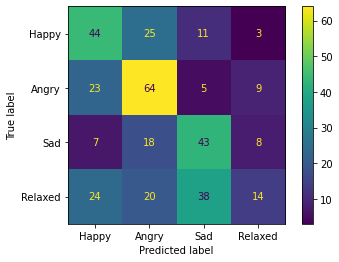

In [12]:
# Baseline Evaluation of the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

### Introducing a New Model for Comparison

#### The Decision Tree Model

In [13]:
# Step 3: Train the Decision Tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train);

Accuracy: 0.8370786516853933
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        83
           1       0.83      0.77      0.80       101
           2       0.81      0.87      0.84        76
           3       0.91      0.89      0.90        96

    accuracy                           0.84       356
   macro avg       0.84      0.84      0.84       356
weighted avg       0.84      0.84      0.84       356



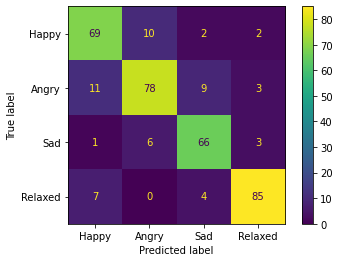

In [14]:
# Step 4: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

cm_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=mood_list)
cm_disp.plot()
plt.show()

***Discussion of Comparison of baseline model results***

## Evaluation

Baseline results of the model showed decision trees to be the superior model, with an accuracy score of 0.83. The logistic regression model had an accuracy score of 0.54. The decision tree model was also able to predict the dominant mood of a song with a 0.45 accuracy score. After tuning both models further, the decision tree model was able to achieve an accuracy score of 0.85, and the logistic regression model was able to achieve an accuracy score of 0.55. The decision tree model was also able to predict the dominant mood of a song with a 0.46 accuracy score.

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Based on the analysis, the author recommends the use of audio feature data to predict the dominant mood of a song. The author also recommends the use of a decision tree model to predict the dominant mood of a song based on it's audio features. The author does not recommend the use of a logistic regression model to predict the dominant mood of a song based on it's audio features.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***